In [10]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import sparse

%matplotlib inline

# Лабораторная работа №2. Методы решения СЛАУ

### Аннотация
В ходе данной лабораторной работы были исследованы прямые и точные методы решения СЛАУ. Для прямых методов приведено полученное значение невязки, для итерационных - график зависимости невязки от итерации.

Исследуемая СЛАУ (о)):
$$
\begin{cases} 
ax_1 + x_2 + \frac{x_3}{b} = 1 \\ 
x_1 + ax_2 + x_3 + \frac{x_4}{b} = 2 \\ 
x_2 + ax_3 + x_4 + \frac{x_5}{b} = 3 \\ 
\cdots \\ 
x_{m-1} + ax_m + x_{m+1} + \frac{x_{m+2}}{b} = m \\ 
\cdots \\ 
x_{n-2} + ax_{n-1} + x_n = n-1 \\ 
x_{n-1} + ax_n = n 
\end{cases}
$$

### Теория
- Метод Гаусса с выбором главного элемента

Метод Гаусса с выбором главного элемента является модификацией метода Гаусса, которая направлена на устранение некоторых недостатков последнего. На i-ом шаге прямого хода, перед делением на диагональный элемент, находится главный элемент (наибольший по модулю элемент среди рассматриваемых). Затем уравнения и столбцы неизвестных переставляются так, чтобы на пересечении i-ой строки и i–го столбца оказался главный элемент, а затем уже выполняется i– ый шаг прямого хода метода Гаусса.

- LU-разложение

LU-разложение — это представление матрицы A в виде A=L•U, где L — нижнетреугольная матрица с еденичной диагональю, а U — верхнетреугольная матрица. 
Алгоритм решения:
1. Разложить матрицу A = LU
2. Решить Lz = b
3. Решить Ux = x

- Метод Якоби

Метод Якоби - итерационный метод решения СЛАУ, основанный на представлении 
матрицы A в виде суммы диагональной и остаточной частей.

Итерационная формула:
$$x_i^{(k+1)} = \frac{1}{a_{ii}} \left(b_i - \sum_{j \neq i} a_{ij}x_j^{(k)}\right)$$

- Метод Зейделя

Метод Зейделя - модификация метода Якоби, использующая уже вычисленные 
компоненты нового приближения на текущей итерации.

Итерационная формула:
$$x_i^{(k+1)} = \frac{1}{a_{ii}} \left(b_i - \sum_{j=1}^{i-1} a_{ij}x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij}x_j^{(k)}\right)$$

- Метод верхней релаксации

Метод верхней релаксации - обобщение метода Зейделя с параметром релаксации ω.
При ω > 1 метод называется верхней релаксацией, при ω < 1 - нижней релаксацией.

Итерационная формула:
$$x_i^{(k+1)} = (1-\omega)x_i^{(k)} + \frac{\omega}{a_{ii}} \left(b_i - \sum_{j=1}^{i-1} a_{ij}x_j^{(k+1)} - \sum_{j=i+1}^{n} a_{ij}x_j^{(k)}\right)$$

- Метод градиентного спуска

Это итерационный метод, предсавляющий собой "движение" против направления наибольшего возрастания функции. Соответственно, $x_{k+1}$ пределяется как:
$$
    x_{k+1} = x_{k} - \alpha \cdot grad(F(x))
$$

$$
    F(x) = \frac{1}{2}\|A\mathbf{x} - \mathbf{b}\|^2
$$

$$
    grad(F(x)) = A^{T} \cdot (Ax - b)
$$

r - невязка, которая определяется как:
$$
    r_k = Ax_k - b
$$

- Метод минимальных невязок

Метод минимальных невязок - вариант метода градиентного спуска с оптимальным выбором 
шага на каждой итерации (минимизация нормы невязки).

Итерационная формула:
$$x_{k+1} = x_k - \tau_k r_k$$
где $\tau_k = \frac{(Ar_k, r_k)}{(Ar_k, Ar_k)}$

In [11]:
class Norm:
    def __init__(self, norm, name):
        self.norm = norm
        self.name = name
def norm_1(x):
    return np.linalg.norm(x, ord = np.inf)

def norm_2(x):
    return np.linalg.norm(x, ord = 1)

def norm_3(x):
    return np.linalg.norm(x, ord = 2)

#Инициализация исследуемой матрицы:
e = 1e-6
n = 100
a, b = 10, 10

A = np.array([max(0, m-1) * [0] + int(m > 0) * [1] + [a] + int(m+1 < n) * [1] + int(m+2 < n) * [1] + max(n-m-3, 0) * [0] for m in range(n)],
             dtype=float)
f = np.arange(1, n+1, dtype=float)

norms = [Norm(norm_1, "Norm 1"), Norm(norm_2, "Norm 2"), Norm(norm_3, "Norm 3")]

# Метод Гаусса с выбором главного элемента

In [12]:
def swap_rows(A, f, i, j):
    A[[i, j]] = A[[j, i]]
    f[i], f[j] = f[j], f[i]

def swap_columns(A, pos, i, j):
    A = A.T
    A[[i, j]] = A[[j, i]]
    A = A.T
    pos[i], pos[j] = pos[j], pos[i]

def pivoting(A, f, pos, i, j, e, n):
    pivot = A[i, j]
    k_pivot, l_pivot = i, j

    for k in range(i, n):
        for l in range(j, n):
            if np.abs(A[k, l]) > np.abs(pivot):
                pivot = A[k, l]
                k_pivot, l_pivot = k, l

    if np.abs(pivot) < e:
        raise RuntimeError("Cannot find a pivot")

    if i != k_pivot:
        swap_rows(A, f, i, k_pivot)
    if j != l_pivot:
        swap_columns(A, pos, j, l_pivot)

def gauss(A_, f_, e, n):
    A = A_.copy()
    f = f_.copy()
    pos = np.arange(0, n, dtype=int)
    x = np.zeros(n, dtype=float)

    for k in range(n - 1):
        pivoting(A, f, pos, k, k, e, n)

        for i in range(k+1, n):
            t = A[i, k] / A[k, k]
            f[i] -= t * f[k]

            for j in range(k+1, n):
                A[i, j] -= t * A[k, j]

    x[n-1] = f[n-1] / A[n-1, n-1]
    for k in range(n-2, -1, -1):
        subtract = 0.0
        for j in range(k+1, n):
            subtract += A[k, j] * x[j]

        x[k] = (f[k] - subtract) / A[k, k]

    ans = np.zeros(n, dtype=float)
    for i in range(n):
        ans[pos[i]] = x[i]
    return ans

x = gauss(A, f, e, n)

for norm in norms:
    print(f"Residual of Gaussian elimination in {norm.name}: {norm.norm(f-A.dot(x))}")

Residual of Gaussian elimination in Norm 1: 4.263256414560601e-14
Residual of Gaussian elimination in Norm 2: 5.184741524999481e-13
Residual of Gaussian elimination in Norm 3: 9.917243891147147e-14


# LU-разложение

In [13]:
def check_LU(A, e, n):
    for i in range(n):
        if np.abs(np.linalg.det(A[:i, :i])) < e:
            return False

    return True

def LU_decomposition(A_, e, n):
    A = A_.copy()

    for i in range(1, n):
        for k in range(i):
            A[i, k] /= A[k, k]

            for j in range(k+1, n):
                A[i, j] -= A[i, k] * A[k, j]

    L = np.eye(n, dtype=float)
    for i in range(n):
        for j in range(i):
            L[i, j] = A[i, j]

    U = np.zeros_like(A)
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j]

    return L, U

def LU_solution(L_, U_, f_, n):
    L, U, f = L_.copy(), U_.copy(), f_.copy()
    x, y = np.zeros(n, dtype=float), np.zeros(n, dtype=float)

    for i in range(n):
        subtract = 0.0
        for k in range(i):
            subtract += L[i, k] * y[k]
        y[i] = f[i] - subtract

    for i in range(n-1, -1, -1):
        subtract = 0.0
        for k in range(i+1, n):
            subtract += U[i, k] * x[k]
        x[i] = (y[i] - subtract) / U[i, i]

    return x

if check_LU(A, e, n):
    L, U = LU_decomposition(A, e, n)

    x = LU_solution(L, U, f, n)
    for norm in norms:
        print(f"Residual of LU-decomposition in {norm.name}: {norm.norm(f-A.dot(x))}")

Residual of LU-decomposition in Norm 1: 1.4210854715202004e-14
Residual of LU-decomposition in Norm 2: 3.765876499528531e-13
Residual of LU-decomposition in Norm 3: 6.689109846918033e-14


# Метод Якоби

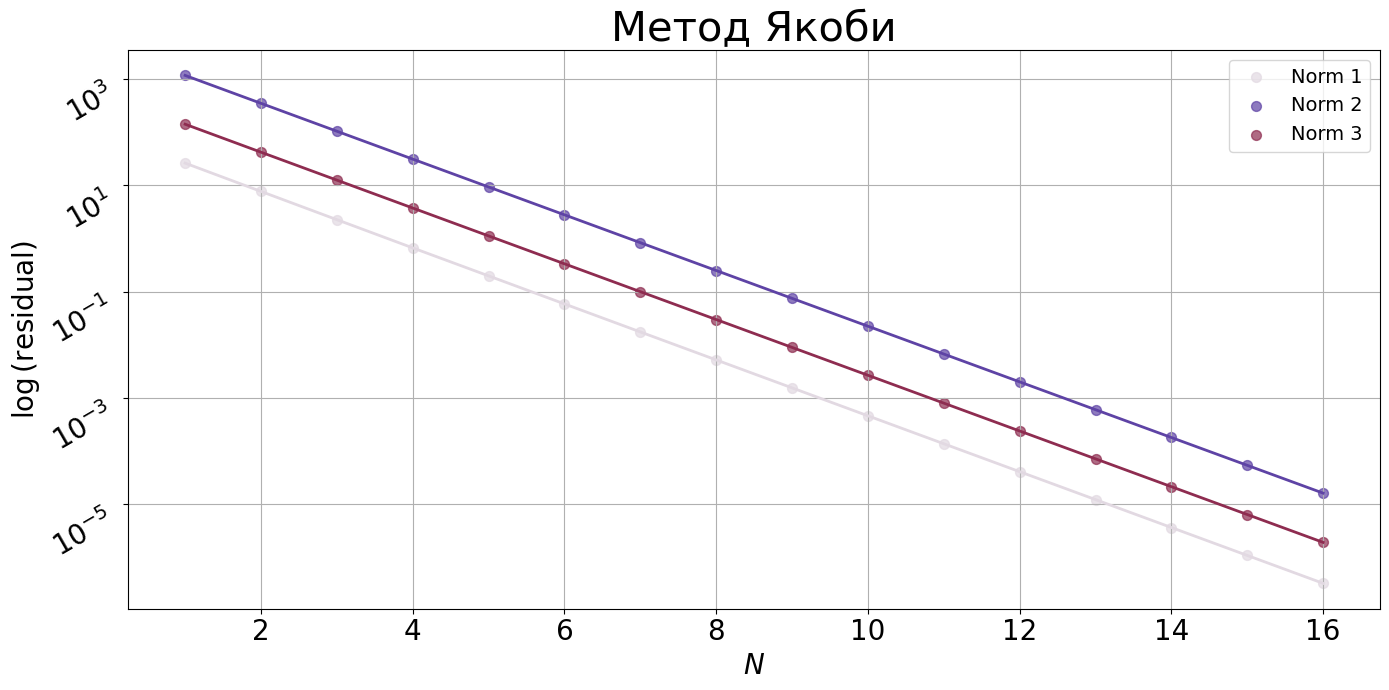

In [25]:
def jacobi(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            for j in range(i):
                y[i] += A[i, j] * x[j]
            for j in range(i+1, n):
                y[i] += A[i, j] * x[j]

            y[i] = (f[i] - y[i]) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = jacobi(A, f, x_0, e, n)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Метод Якоби", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")

plt.grid(which="both")

cmap = plt.get_cmap('twilight')

num_norms = len(norms)
colors = [cmap(i / num_norms) for i in range(num_norms)]

for i, (residual, norm) in enumerate(zip(residuals, norms)):
    color = colors[i]
    plt.scatter(iterations, residual, label=norm.name, color=color, s=50, alpha=0.7)
    plt.plot(iterations, residual, color=color, linewidth=2)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()

# Метод Зейделя

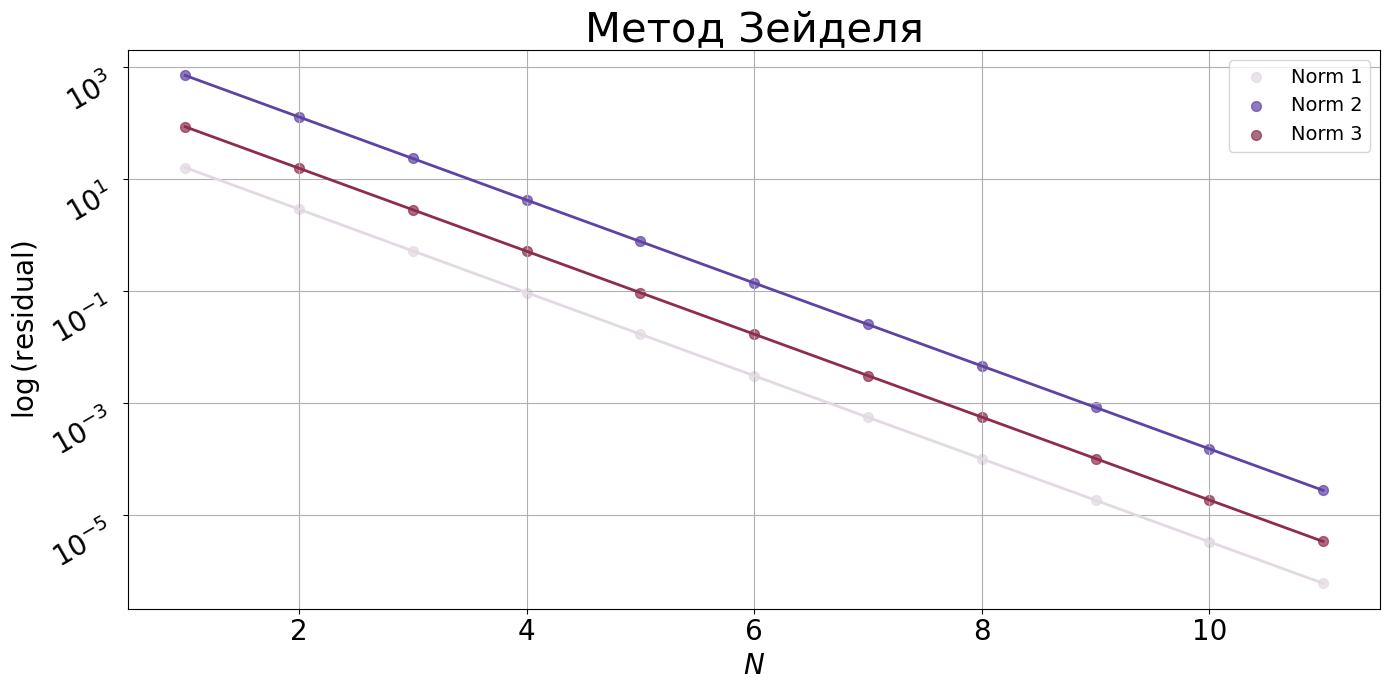

In [26]:
def seidel(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            y[i] = (f[i] - sigma) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = seidel(A, f, x_0, e, n)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Метод Зейделя", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")

plt.grid(which="both")

cmap = plt.get_cmap('twilight')

num_norms = len(norms)
colors = [cmap(i / num_norms) for i in range(num_norms)]

for i, (residual, norm) in enumerate(zip(residuals, norms)):
    color = colors[i]
    plt.scatter(iterations, residual, label=norm.name, color=color, s=50, alpha=0.7)
    plt.plot(iterations, residual, color=color, linewidth=2)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()

# Метод верхней релаксации

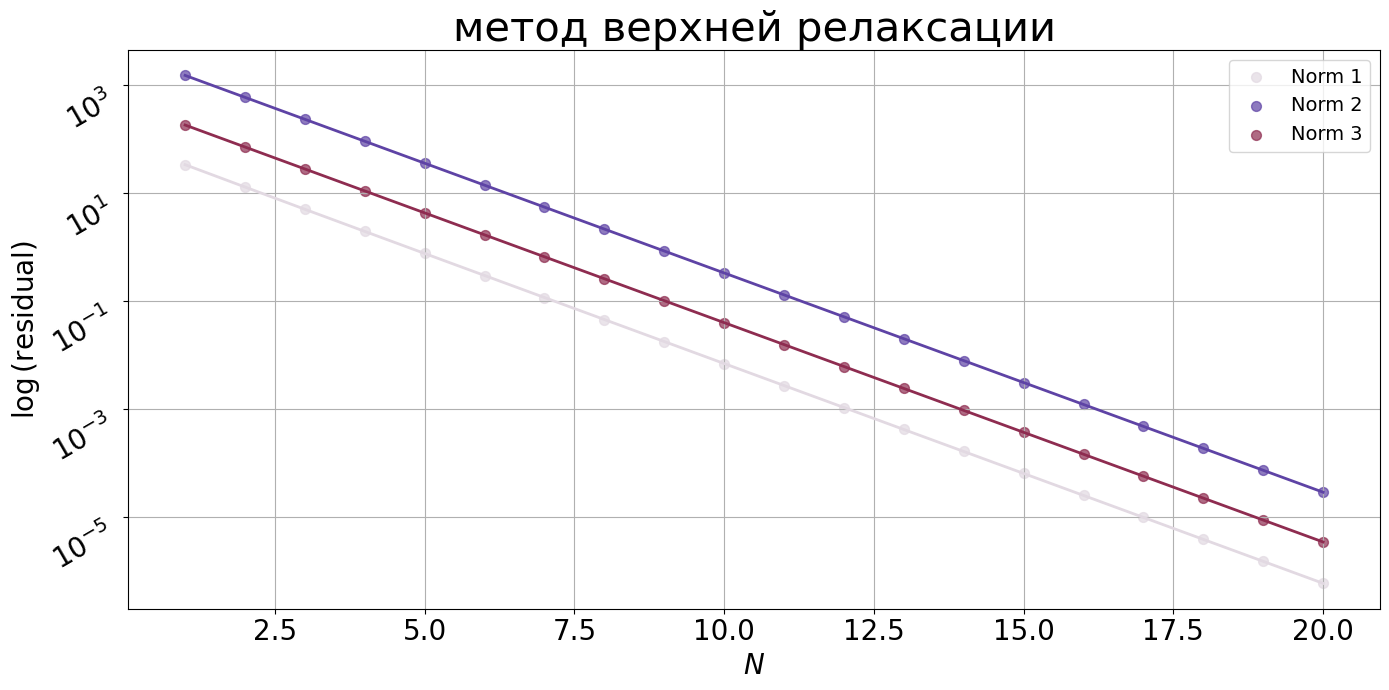

In [27]:
def SOR(A, f, x_0, w, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            sigma = (f[i] - sigma) / A[i, i]
            y[i] = x[i] + w * (sigma - x[i])
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

w = 1.2
x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = SOR(A, f, x_0, w, e, n)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("метод верхней релаксации", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")

plt.grid(which="both")

cmap = plt.get_cmap('twilight')

num_norms = len(norms)
colors = [cmap(i / num_norms) for i in range(num_norms)]

for i, (residual, norm) in enumerate(zip(residuals, norms)):
    color = colors[i]
    plt.scatter(iterations, residual, label=norm.name, color=color, s=50, alpha=0.7)
    plt.plot(iterations, residual, color=color, linewidth=2)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()

# Метод градиентного спуска

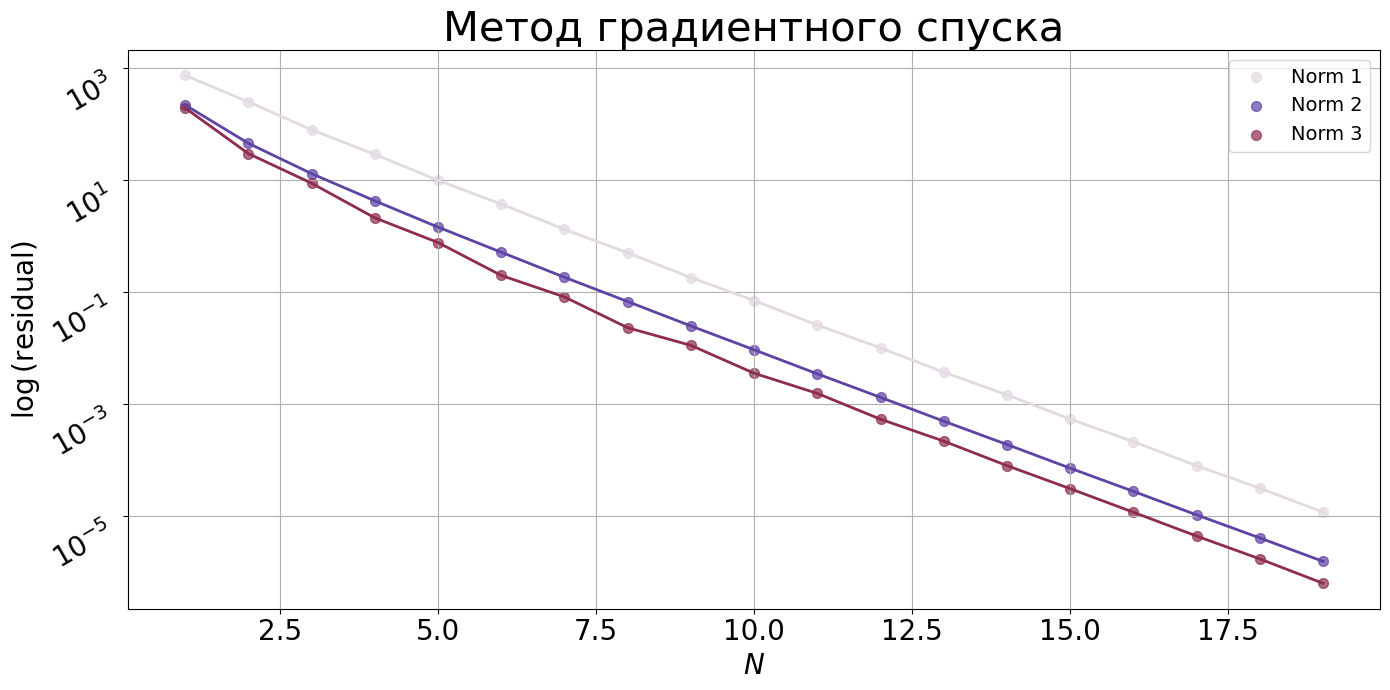

In [28]:
def FGD(A_, f_, x_0, e):
    m, n = A_.shape

    A = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            for k in range(m):
                A[i][j] += A_[k][i] * A_[k][j]

    f = [0.0] * n
    for i in range(n):
        for k in range(m):
            f[i] += A_[k][i] * f_[k]

    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while True:
        r = [0.0] * n
        for i in range(n):
            r_i = -f[i]
            for j in range(n):
                r_i += A[i][j] * x[j]
            r[i] = r_i

        norm1 = 0.0
        norm2 = 0.0
        norm3 = 0.0
        for i in range(n):
            abs_r = abs(r[i])
            norm1 += abs_r
            norm2 += r[i] * r[i]
            if abs_r > norm3:
                norm3 = abs_r
        norm2 = norm2 ** 0.5

        min_norm = min(norm1, norm2, norm3)
        if min_norm <= e:
            break

        Ar = [0.0] * n
        for i in range(n):
            for j in range(n):
                Ar[i] += A[i][j] * r[j]

        numerator = 0.0
        for i in range(n):
            numerator += r[i] * r[i]

        denominator = 0.0
        for i in range(n):
            denominator += Ar[i] * r[i]

        tau = numerator / denominator

        for i in range(n):
            x[i] = x[i] - tau * r[i]

        new_r = [0.0] * n
        for i in range(n):
            new_r_i = -f[i]
            for j in range(n):
                new_r_i += A[i][j] * x[j]
            new_r[i] = new_r_i

        norm1_new = 0.0
        norm2_new = 0.0
        norm3_new = 0.0
        for i in range(n):
            abs_new_r = abs(new_r[i])
            norm1_new += abs_new_r
            norm2_new += new_r[i] * new_r[i]
            if abs_new_r > norm3_new:
                norm3_new = abs_new_r
        norm2_new = norm2_new ** 0.5

        residuals_1.append(norm1_new)
        residuals_2.append(norm2_new)
        residuals_3.append(norm3_new)

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = FGD(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Метод градиентного спуска", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")

plt.grid(which="both")

cmap = plt.get_cmap('twilight')

num_norms = len(norms)
colors = [cmap(i / num_norms) for i in range(num_norms)]

for i, (residual, norm) in enumerate(zip(residuals, norms)):
    color = colors[i]
    plt.scatter(iterations, residual, label=norm.name, color=color, s=50, alpha=0.7)
    plt.plot(iterations, residual, color=color, linewidth=2)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()


# Метод минимальных невязок

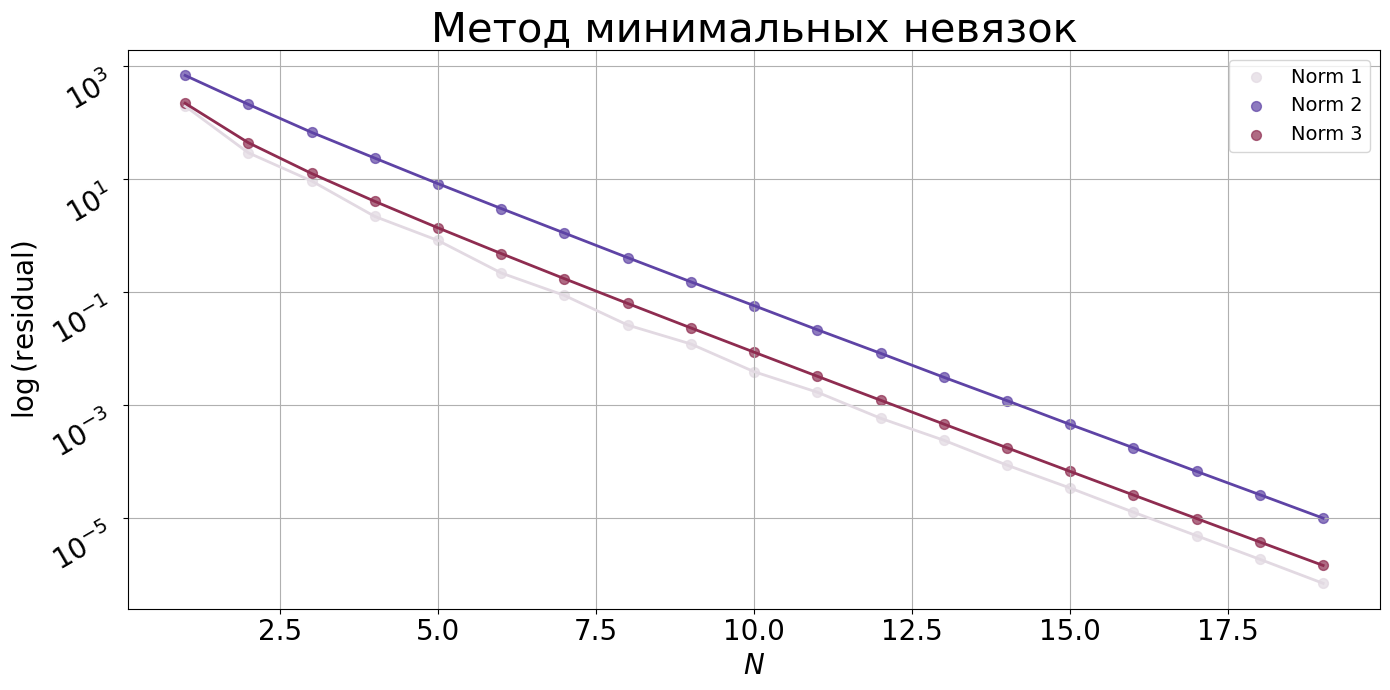

In [29]:
def MRM(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        tau = (A.dot(A.dot(x) - f)).dot(A.dot(x) - f) / (A.dot(A.dot(x) - f)).dot(A.dot(A.dot(x) - f))
        x -= tau * (A.dot(x) - f)

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3


x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = MRM(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Метод минимальных невязок", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")

plt.grid(which="both")

cmap = plt.get_cmap('twilight')

num_norms = len(norms)
colors = [cmap(i / num_norms) for i in range(num_norms)]

for i, (residual, norm) in enumerate(zip(residuals, norms)):
    color = colors[i]
    plt.scatter(iterations, residual, label=norm.name, color=color, s=50, alpha=0.7)
    plt.plot(iterations, residual, color=color, linewidth=2)

plt.legend(loc="best", fontsize=14)
plt.tight_layout()
plt.show()